## Adopt BLIP2 and LLM to solve content moderation

This notebook demonstrate how we can adopt BLIP2 and LLM for content moderation. To align with the tradicitonal approach as [Moderating content](https://docs.aws.amazon.com/rekognition/latest/dg/moderation.html), we also categorize contents into different categories. For each category, like check-list we define questions to check if the content belongs to that category. For few questions, we may just check if all answers meet the defined answers, but for many questions with different type answers, designing rule-based process may be complicated, therefore we leverage LLM to summarize the result based on the questions and answers from BLIP2 model. 


The illustration is below: 
<div align="center">
    <img src="images/illustrationCM.png" />
</div>




The notebook has been tested within SageMaker Studio Notebook environment Python3 Data Science environment. 


## Setup 

In [1]:
from PIL import Image
import base64
import json
import boto3

smr_client = boto3.client("sagemaker-runtime")
boto3_bedrock = boto3.client('bedrock-runtime')
%store -r endpoint_name

In [2]:
def encode_image(img_file):
    with open(img_file, "rb") as image_file:
        img_str = base64.b64encode(image_file.read())
        base64_string = img_str.decode("latin1")
    return base64_string

def run_inference(endpoint_name, inputs):
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name, Body=json.dumps(inputs)
    )
    return response["Body"].read().decode('utf-8')

## Run BLIP2 to extract text information from image

### Define questions
We define a list of questions without category setting, and put all QA results into prompt for LLM, ask LLM to categorize if the content is unsafe.

In [3]:
check_list = [
    "Does this photo contain complete naked person?",
    "Does this photo contain topless person?",
    "Does this photo contain weapon?",
    "Does this photo contain contact information?",
    "Does this photo contain a smoker?",
    "Does this photo contain blood?",
    "Are there persons fighting in this photo?",
    "Does this photo contain harassment words?"
]

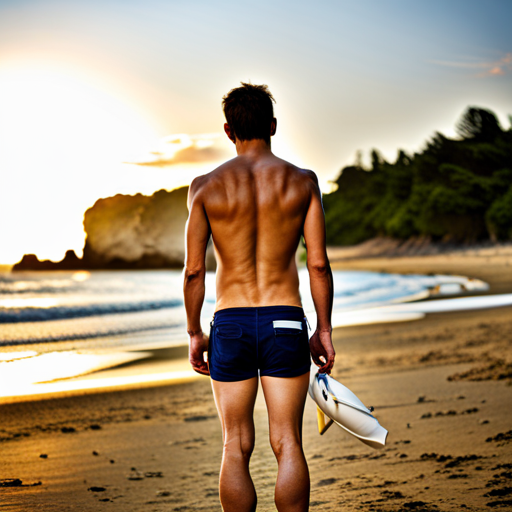

In [4]:
test_image = "./surf_swimwear.png"
raw_image = Image.open(test_image).convert('RGB')
display(raw_image)

### run inference

In [5]:
base64_string = encode_image(test_image)

inputs = {"prompt": "Question: describe the detailed content in 200 words. Answer:", "image": base64_string}
response = smr_client.invoke_endpoint(
    EndpointName=endpoint_name, Body=json.dumps(inputs)
)
image_caption = response["Body"].read().decode('utf-8')
image_caption

'a man is standing on the beach with a surfboard'

In [6]:
def run_check_list(test_image, check_list):
    base64_string = encode_image(test_image)
    conversations = """"""
    for question in check_list:
        inputs = {"prompt": f"Question: {question}? Answer:", "image": base64_string}
        response = run_inference(endpoint_name, inputs)
        conversations += f"""
Question: {question}
Answer: {response}.
"""
    return conversations

In [7]:
conversations = run_check_list(test_image, check_list)

In [8]:
conversations

'\nQuestion: Does this photo contain complete naked person?\nAnswer: no.\n\nQuestion: Does this photo contain topless person?\nAnswer: yes.\n\nQuestion: Does this photo contain weapon?\nAnswer: no.\n\nQuestion: Does this photo contain contact information?\nAnswer: no.\n\nQuestion: Does this photo contain a smoker?\nAnswer: no.\n\nQuestion: Does this photo contain blood?\nAnswer: no.\n\nQuestion: Are there persons fighting in this photo?\nAnswer: no.\n\nQuestion: Does this photo contain harassment words?\nAnswer: no.\n'

In [9]:
conversations += f"""
Question: What does this photo contain?
Answer: {image_caption}.
"""

## Summarize questions and answers with LLM

Before running this section, make sure you have access to Amazon bedrock Claude 2 model.

### Define policy
We prepare moderation policy by referring to [Moderating content](https://docs.aws.amazon.com/rekognition/latest/dg/moderation.html).

In [10]:
moderation_policy = """
1. Explicit Nudity: it contains Nudity, Graphic Male Nudity, Graphic Female Nudity, Sexual Activity, Illustrated Explicit Nudity and Adult Toys.
2. Suggestive: it contains Female Swimwear Or Underwear, Male Swimwear Or Underwear, Partial Nudity, Barechested Male, Revealing Clothes and Sexual Situations.
3. Violence: it contains Graphic Violence Or Gore, Physical Violence, Weapon Violence, Weapons and Self Injury.
4. Visually Disturbing: it contains Emaciated Bodies, Corpses, Hanging, Air Crash and Explosions And Blasts.
5. Rude Gestures: it contains Middle Finger.
6. Drugs: it contains Drug Products, Drug Use, Pills and Drug Paraphernalia.
7. Tobacco: it contains contain Tobacco Products and Smoking.
8. Alcohol: it contains Drinking and Alcoholic Beverages.
9. Gambling: it contains Gambling.
10. Hate Symbols: it contains Nazi Party, White Supremacy and Extremist.
"""

### Define prompt template

In [11]:
prompt_template = f"""
The following is our company's content moderation policy, based on the moderation policy, we gather image information from the user uploaded image. Each question in the image information corresponds to a moderation policy. If the answer to the question is yes, that means the image contains information that flagged as unsafe against that policy. Please answer the question with json format. 
        
###### moderation policy ######
{moderation_policy}
        
###### Image information ######
{conversations}
        
###### Question ######
Based on the following Moderation policy and QA, tell me if the photo containes unsafe content, also give its category and reason if it's unsafe. Please anwser the question with the following format and only put explanation into the reason field:  
"""

prompt_template += """
{
    "flag": "xxx",
    "category": "xxx",
    "reason": "the reason is ..."
}
"""

In [12]:
payload = {
    "prompt": f"\n\nHuman: {prompt_template}\n\nAssistant:", 
    "max_tokens_to_sample": 300, 
    "top_p": 0.9, 
    "temperature": 0.5
}

In [13]:
accept = 'application/json'
contentType = 'application/json'
response = boto3_bedrock.invoke_model(body=json.dumps(payload), 
                                      modelId='anthropic.claude-v2', 
                                      accept=accept, 
                                      contentType=contentType
                                     )
response_body = json.loads(response.get('body').read())

# text
print(response_body.get('completion'))

 {
    "flag": "yes",
    "category": "Suggestive",
    "reason": "The photo contains topless person which is categorized as Partial Nudity under Suggestive content according to the moderation policy."
}


In [14]:
print(f"{prompt_template}\n")
print(f"Response > \n {response_body.get('completion')}")
print("\n==================================\n")


The following is our company's content moderation policy, based on the moderation policy, we gather image information from the user uploaded image. Each question in the image information corresponds to a moderation policy. If the answer to the question is yes, that means the image contains information that flagged as unsafe against that policy. Please answer the question with json format. 
        
###### moderation policy ######

1. Explicit Nudity: it contains Nudity, Graphic Male Nudity, Graphic Female Nudity, Sexual Activity, Illustrated Explicit Nudity and Adult Toys.
2. Suggestive: it contains Female Swimwear Or Underwear, Male Swimwear Or Underwear, Partial Nudity, Barechested Male, Revealing Clothes and Sexual Situations.
3. Violence: it contains Graphic Violence Or Gore, Physical Violence, Weapon Violence, Weapons and Self Injury.
4. Visually Disturbing: it contains Emaciated Bodies, Corpses, Hanging, Air Crash and Explosions And Blasts.
5. Rude Gestures: it contains Middle F